In [360]:
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_helper import rel_slicer
from PW_explorer.time_series import PWETimeSeriesModule
from PW_explorer.pwe_nb_helper import ASPRules
from PW_explorer.export import PWEExport
from PW_explorer.visualize import PWEVisualization

import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
from copy import deepcopy
from collections import OrderedDict

import csv

In [2]:
%load_ext PWE_NB_Extension

In [125]:
def turn_list_into_str(l):
    # small bug fix 
    if isinstance(l, (list,set,frozenset)):
        if len(l) > 1:
            l_ = [turn_list_into_str(l1) for l1 in l[1:]]
            return "{}({})".format(l[0], ",".join(l_))
        elif len(l) == 1:
            return "{}".format(l[0])
        else:
            return ""
    else:
        return l


In [3]:
testData = '/home/mj1e16/abduction/pwe/testData/qfix_synthetic_example/synth_1_dirty_0.csv'
testQueries = '/home/mj1e16/abduction/pwe/testData/qfix_synthetic_example/qlog_clean.csv'

In [154]:
testQueries = '/home/mj1e16/abduction/pwe/testData/qfixNew/qfix_sync/synth/qlog_New.csv'

In [4]:
dataSet = []
with open(testData,'r') as csvfile:
    reader = csv.reader(csvfile,delimiter=' ',quotechar='|')
    for row in reader:
        dataSet.append([', '.join(row)])

In [11]:
clingo_rules

['% schema data(ID,A0,A1,A2,A3,A4,A5)',
 ['% schema e(dataEnd,dataStart,trans)']]

In [10]:
dataSetOnly = dataSet[1:]
originalSchema = dataSet[0][0].upper()
endSchema = originalSchema.replace(',',',END')
end = 'END'
endSchema = end + endSchema
clingo_rules = ['% schema data('+originalSchema+',PROV)']
clingo_rules.append(['% schema e(DATAEND,DATASTART,TRANS)'])

In [6]:
schemaList = dataSet[0][0]+ ',COLOUR,TRANS,'
schemaList += endSchema
schemaList = schemaList.split(",")

In [7]:
sql = "UPDATE synth_1_clean_0 SET a1 = 95, a2 = 91 WHERE a1 = 3 AND a5 = 2"
sql = sql.replace(' = ','=')
sql = sql.replace(',','')
sql.split(' ')

['UPDATE',
 'synth_1_clean_0',
 'SET',
 'a1=95',
 'a2=91',
 'WHERE',
 'a1=3',
 'AND',
 'a5=2']

In [155]:
with open(testQueries,'r') as f:
    data = f.read()
print(data)    
queries = data.split('\n')
print(queries)

UPDATE synth_1_clean_0 SET a1 = 95, a2 = 91 WHERE a1 = 3 AND a5 = 2
UPDATE synth_1_clean_1 SET a1 = 38, a2 = 21 WHERE a1 >= 38 AND a1 < 48 AND a4 >= 2 AND a4 < 12
INSERT INTO synth_1_clean_2 VALUES(50,44,50,23,23,22,46)
INSERT INTO synth_1_clean_3 VALUES(51,2,84,56,64,18,100)
UPDATE synth_1_clean_4 SET a1 = 33, a2 = 72 WHERE a1 = 71 AND a5 = 94
UPDATE synth_1_clean_5 SET a1 = 67, a2 = 30 WHERE a1 >= 53 AND a1 < 63 AND a4 >= 80 AND a4 < 90
UPDATE synth_1_clean_6 SET a1 = 59, a2 = 3 WHERE a1 >= 22 AND a1 < 32 AND a4 >= 72 AND a4 < 82
UPDATE synth_1_clean_7 SET a1 = 55, a2 = 71 WHERE a1 = 68 AND a5 = 37
UPDATE synth_1_clean_8 SET a1 = 78, a2 = 52 WHERE a1 >= 35 AND a1 < 45 AND a4 >= 44 AND a4 < 54
INSERT INTO synth_1_clean_9 VALUES(52,4,71,99,59,39,17)
UPDATE synth_1_dirty_0 SET a1 = 95, a2 = 27 WHERE a1 = 96 AND a5 = 2
UPDATE synth_1_dirty_1 SET a1 = 38, a2 = 21 WHERE a1 >= 38 AND a1 < 48 AND a4 >= 2 AND a4 < 12
INSERT INTO synth_1_dirty_2 VALUES(50,44,50,23,23,22,46)
INSERT INTO synth_1

In [178]:
def sql2clingo(sqlCommand,originalSchema,colour='black'):
    sql = sqlCommand.replace('"','')
    sqlList = sql.split(' ') 
    print(sqlList)
    schemaList = originalSchema.split(',')
    #print(schemaList)
    clingoString = 0
    #print(sqlList[0])
    if sqlList[0] == 'UPDATE':
        sql = sql.replace(' = ','=')
        sql = sql.replace(' > ','>')
        sql = sql.replace(' < ','<')
        sql = sql.replace(' >= ','>=')
        sql = sql.replace(' <= ','<=')
        sql = sql.replace(',','')
        sqlList = sql.split(' ') 
        setLoc = sqlList.index('SET')
        whereLoc = sqlList.index('WHERE')
        setCommands = sqlList[setLoc+1:whereLoc]
        setCommands = [x.upper() for x in setCommands]
        whereCommands = sqlList[whereLoc+1:]
        whereCommands = [x.upper() for x in whereCommands if x != 'AND']
        whereCommandsString = '-'.join(whereCommands)
        whereCommandsComma = ','.join(whereCommands)
        setLocs = [x[:x.index('=')] for x in setCommands]
        setValues = [x[x.index('=')+1:] for x in setCommands]
        setVals = []
        startSetVals = []
        for x in (schemaList):
            if x in setLocs:
                loc = setLocs.index(x)
                setVals.append(setValues[loc])
                startSetVals.append('_')
            else:
                setVals.append(x)
                startSetVals.append(x)
        setValsString = ','.join(setVals)
        #clingoString = 'data('+setValsString+',black,"'+whereCommandsString+'",'+originalSchema+') :- data('+originalSchema+',_,_,_,_,_,_,_,_,_),'+whereCommandsComma+'.'
        clingoString = 'e(data('+setValsString+',prov(P,"'+whereCommandsString+'")),data('+originalSchema+',P),trans('+colour+',"'+whereCommandsString+'")) :- data('+originalSchema+',P),'+whereCommandsComma+'.'
    if sqlList[0] == 'INSERT':
        locator = 'VALUES('
        loc1 = sql.index(locator)
        loc2 = sql[loc1:].index(')')+loc1
        datavalues = sql[loc1+len(locator):loc2]
        datavaluesDash = datavalues.replace(',','-')
        clingoString = 'data('+datavalues+',"INSERT'+datavaluesDash+'").'
    
    return clingoString

In [179]:
commands = []
for x in queries:
    clingoString = sql2clingo(x,originalSchema)
    if clingoString != 0:
        commands.append(clingoString)
        
commands

['UPDATE', 'synth_1_clean_0', 'SET', 'a1', '=', '95,', 'a2', '=', '91', 'WHERE', 'a1', '=', '3', 'AND', 'a5', '=', '2']
['UPDATE', 'synth_1_clean_1', 'SET', 'a1', '=', '38,', 'a2', '=', '21', 'WHERE', 'a1', '>=', '38', 'AND', 'a1', '<', '48', 'AND', 'a4', '>=', '2', 'AND', 'a4', '<', '12']
['INSERT', 'INTO', 'synth_1_clean_2', 'VALUES(50,44,50,23,23,22,46)']
['INSERT', 'INTO', 'synth_1_clean_3', 'VALUES(51,2,84,56,64,18,100)']
['UPDATE', 'synth_1_clean_4', 'SET', 'a1', '=', '33,', 'a2', '=', '72', 'WHERE', 'a1', '=', '71', 'AND', 'a5', '=', '94']
['UPDATE', 'synth_1_clean_5', 'SET', 'a1', '=', '67,', 'a2', '=', '30', 'WHERE', 'a1', '>=', '53', 'AND', 'a1', '<', '63', 'AND', 'a4', '>=', '80', 'AND', 'a4', '<', '90']
['UPDATE', 'synth_1_clean_6', 'SET', 'a1', '=', '59,', 'a2', '=', '3', 'WHERE', 'a1', '>=', '22', 'AND', 'a1', '<', '32', 'AND', 'a4', '>=', '72', 'AND', 'a4', '<', '82']
['UPDATE', 'synth_1_clean_7', 'SET', 'a1', '=', '55,', 'a2', '=', '71', 'WHERE', 'a1', '=', '68', 'AND',

['e(data(ID,A0,95,91,A3,A4,A5,prov(P,"A1=3-A5=2")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=3-A5=2")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=3,A5=2.',
 'e(data(ID,A0,38,21,A3,A4,A5,prov(P,"A1>=38-A1<48-A4>=2-A4<12")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=38-A1<48-A4>=2-A4<12")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=38,A1<48,A4>=2,A4<12.',
 'data(50,44,50,23,23,22,46,"INSERT50-44-50-23-23-22-46").',
 'data(51,2,84,56,64,18,100,"INSERT51-2-84-56-64-18-100").',
 'e(data(ID,A0,33,72,A3,A4,A5,prov(P,"A1=71-A5=94")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=71-A5=94")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=71,A5=94.',
 'e(data(ID,A0,67,30,A3,A4,A5,prov(P,"A1>=53-A1<63-A4>=80-A4<90")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=53,A1<63,A4>=80,A4<90.',
 'e(data(ID,A0,59,3,A3,A4,A5,prov(P,"A1>=22-A1<32-A4>=72-A4<82")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=22-A1<32-A4>=72-A4<82")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=22

In [209]:
commands = ['data(ID,A0,59,3,A3,A4,A5,black,"A1>=22-A1<32-A4>=72-A4<82",ID,A0,A1,A2,A3,A4,A5) :- data(ID,A0,A1,A2,A3,A4,A5_,_,_,_,_,_,_),A1>=22,A4>=72.']

In [180]:
ASPRules('\n'.join(commands))

'e(data(ID,A0,95,91,A3,A4,A5,prov(P,"A1=3-A5=2")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=3-A5=2")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=3,A5=2.\ne(data(ID,A0,38,21,A3,A4,A5,prov(P,"A1>=38-A1<48-A4>=2-A4<12")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=38-A1<48-A4>=2-A4<12")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=38,A1<48,A4>=2,A4<12.\ndata(50,44,50,23,23,22,46,"INSERT50-44-50-23-23-22-46").\ndata(51,2,84,56,64,18,100,"INSERT51-2-84-56-64-18-100").\ne(data(ID,A0,33,72,A3,A4,A5,prov(P,"A1=71-A5=94")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=71-A5=94")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=71,A5=94.\ne(data(ID,A0,67,30,A3,A4,A5,prov(P,"A1>=53-A1<63-A4>=80-A4<90")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=53,A1<63,A4>=80,A4<90.\ne(data(ID,A0,59,3,A3,A4,A5,prov(P,"A1>=22-A1<32-A4>=72-A4<82")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=22-A1<32-A4>=72-A4<82")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=22,A1<32,A4>=72,A4<82.\ne(data(ID,A0,55,71,A3,A4,A5,prov(P,"A1=68-A5=37")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=68-A5=37")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=68,A5=37.\ne(data(ID,A0,78,52,A3,A4,A5,prov(P,"A1>=35-A1<45-A4>=44-A4<54")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=35-A1<45-A4>=44-A4<54")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=35,A1<45,A4>=44,A4<54.\ndata(52,4,71,99,59,39,17,"INSERT52-4-71-99-59-39-17").\ne(data(ID,A0,95,27,A3,A4,A5,prov(P,"A1=96-A5=2")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=96-A5=2")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=96,A5=2.\ne(data(ID,A0,38,21,A3,A4,A5,prov(P,"A1>=38-A1<48-A4>=2-A4<12")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=38-A1<48-A4>=2-A4<12")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=38,A1<48,A4>=2,A4<12.\ndata(50,44,50,23,23,22,46,"INSERT50-44-50-23-23-22-46").\ndata(51,2,84,56,64,18,100,"INSERT51-2-84-56-64-18-100").\ne(data(ID,A0,33,72,A3,A4,A5,prov(P,"A1=71-A5=94")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=71-A5=94")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=71,A5=94.\ne(data(ID,A0,67,30,A3,A4,A5,prov(P,"A1>=53-A1<63-A4>=80-A4<90")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=53,A1<63,A4>=80,A4<90.\ne(data(ID,A0,59,3,A3,A4,A5,prov(P,"A1>=22-A1<32-A4>=72-A4<82")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=22-A1<32-A4>=72-A4<82")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=22,A1<32,A4>=72,A4<82.\ne(data(ID,A0,55,71,A3,A4,A5,prov(P,"A1=68-A5=37")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=68-A5=37")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=68,A5=37.\ne(data(ID,A0,78,52,A3,A4,A5,prov(P,"A1>=35-A1<45-A4>=44-A4<54")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=35-A1<45-A4>=44-A4<54")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=35,A1<45,A4>=44,A4<54.\ndata(52,4,71,99,59,39,17,"INSERT52-4-71-99-59-39-17").\ne(data(ID,A0,44,54,A3,A4,A5,prov(P,"A4>=24-A4<34-A2>=3-A2<13")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A4>=24-A4<34-A2>=3-A2<13")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A4>=24,A4<34,A2>=3,A2<13.\ndata(50,46,32,38,90,53,56,"INSERT50-46-32-38-90-53-56").\ndata(51,2,32,13,51,100,68,"INSERT51-2-32-13-51-100-68").\ndata(52,90,80,74,91,77,79,"INSERT52-90-80-74-91-77-79").\ne(data(ID,A0,16,97,A3,A4,A5,prov(P,"A4>=68-A4<78-A2>=65-A2<75")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A4>=68-A4<78-A2>=65-A2<75")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A4>=68,A4<78,A2>=65,A2<75.\ne(data(ID,A0,93,49,A3,A4,A5,prov(P,"A4>=45-A4<55-A2>=75-A2<85")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A4>=45-A4<55-A2>=75-A2<85")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A4>=45,A4<55,A2>=75,A2<85.\ne(data(ID,A0,46,90,A3,A4,A5,prov(P,"A4>=51-A4<61-A2>=83-A2<93")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A4>=51-A4<61-A2>=83-A2<93")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A4>=51,A4<61,A2>=83,A2<93.\ne(data(ID,A0,32,22,A3,A4,A5,prov(P,"A0=70-A2=16")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A0=70-A2=16")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A0=70,A2=16.\ne(data(ID,A0,31,92,A3,A4,A5,prov(P,"A0=96-A2=71")),data(ID,A0,A1,A2,A3,

In [186]:
sql = "INSERT INTO synth_1_clean_9 VALUES(52,4,71,99,59,39,17)"


In [187]:
sql2clingo(sql,originalSchema)

INSERT


'data(52,4,71,99,59,39,17,black,"-",52,4,71,99,59,39,17).'

In [29]:
def makeOriginal(dataValues,colour='black'):
    clingoStart = []
    for x in dataValues:
        clingoStart.append('data('+','.join(x)+',"").')
    return clingoStart

In [30]:
originalSetup = makeOriginal(dataSetOnly)

In [31]:
ASPRules('\n'.join(originalSetup))

'data(0,13,85,77,27,52,48,"").\ndata(1,65,79,11,5,85,46,"").\ndata(2,76,1,46,73,26,95,"").\ndata(3,91,4,4,56,95,41,"").\ndata(4,21,43,4,24,46,52,"").\ndata(5,23,24,23,48,32,7,"").\ndata(6,84,56,65,21,100,87,"").\ndata(7,12,34,73,72,94,45,"").\ndata(8,83,68,32,60,89,86,"").\ndata(9,51,59,5,26,81,44,"").\ndata(10,17,55,71,69,40,47,"").\ndata(11,51,78,53,41,51,7,"").\ndata(12,4,71,99,61,42,21,"").\ndata(13,50,99,78,55,87,27,"").\ndata(14,51,96,59,47,30,57,"").\ndata(15,96,1,79,83,89,76,"").\ndata(16,81,52,57,44,9,88,"").\ndata(17,57,20,51,50,38,38,"").\ndata(18,54,63,62,47,6,27,"").\ndata(19,17,59,87,81,81,83,"").\ndata(20,25,85,68,11,5,6,"").\ndata(21,76,25,12,64,37,11,"").\ndata(22,16,53,18,29,73,48,"").\ndata(23,32,48,4,40,44,23,"").\ndata(24,10,90,52,23,62,83,"").\ndata(25,2,2,16,73,19,72,"").\ndata(26,68,55,23,98,81,54,"").\ndata(27,22,65,41,59,35,65,"").\ndata(28,5,30,97,88,33,87,"").\ndata(29,31,94,75,43,28,5,"").\ndata(30,88,4,83,97,59,21,"").\ndata(31,87,98,71,52,40,38,"").\ndata(32,20,68,44,22,14,68,"").\ndata(33,29,50,34,88,91,6,"").\ndata(34,20,33,99,79,36,25,"").\ndata(35,68,84,94,36,89,70,"").\ndata(36,48,99,25,74,12,21,"").\ndata(37,92,22,77,61,85,40,"").\ndata(38,34,30,87,62,96,90,"").\ndata(39,13,56,12,6,11,88,"").\ndata(40,79,83,35,63,79,41,"").\ndata(41,57,23,10,29,90,59,"").\ndata(42,93,46,29,80,84,6,"").\ndata(43,67,10,13,89,7,28,"").\ndata(44,99,43,13,19,27,76,"").\ndata(45,10,92,39,98,92,33,"").\ndata(46,25,48,11,66,7,6,"").\ndata(47,99,30,61,47,34,11,"").\ndata(48,92,97,98,13,24,64,"").\ndata(49,98,55,70,67,29,56,"").'

In [50]:
def addConversion(dataValues):
    variables = []
    spaces = ['_']*len(dataValues)
    #underscores = ','.join(spaces)
        
    variables = [chr(65+x) for x in range(len(dataValues))]
    clingoHead = 'data('+','.join(variables)+',P) :-'
    clingoBody = 'e(data('+','.join(variables)+',P),data('+','.join(spaces)+',P),trans(_,T)).'
    
    
    return clingoHead+clingoBody

In [51]:
originalSchema
print(originalSchema.split(','))

['ID', 'A0', 'A1', 'A2', 'A3', 'A4', 'A5']


In [52]:
edgeNodeConv = addConversion(originalSchema.split(','))

In [53]:
ASPRules(edgeNodeConv)

'data(A,B,C,D,E,F,G,P) :-e(data(A,B,C,D,E,F,G,P),data(_,_,_,_,_,_,_,P),trans(_,T)).'

In [143]:
originalSchema

'ID,A0,A1,A2,A3,A4,A5'

In [181]:
clingo_rules = ['% schema data('+originalSchema+',prov)','% schema e(DATAEND,DATASTART,TRANS)']
clingo_rules.extend(originalSetup)
clingo_rules.extend(commands)
clingo_rules.extend([edgeNodeConv])

In [182]:
# clingo_rules = ['% schema data(TEXT)','% schema result(GH,DJ)']
# clingo_rules.extend(['data("1").','data("2").'])
# clingo_rules.extend(['result(B,A) :- data(A),data(B).'])
# ASPRules('\n'.join(clingo_rules)) # A5 is unsafe but I don't know why
# %clingo -l clingo_rules --saveto clingo_soln --save_meta_data_to meta_data --donot-display_input
# pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo')
# pw_rels_dfs.keys()


In [183]:
ASPRules('\n'.join(clingo_rules)) 

'% schema data(ID,A0,A1,A2,A3,A4,A5,prov)\n% schema e(DATAEND,DATASTART,TRANS)\ndata(0,13,85,77,27,52,48,"").\ndata(1,65,79,11,5,85,46,"").\ndata(2,76,1,46,73,26,95,"").\ndata(3,91,4,4,56,95,41,"").\ndata(4,21,43,4,24,46,52,"").\ndata(5,23,24,23,48,32,7,"").\ndata(6,84,56,65,21,100,87,"").\ndata(7,12,34,73,72,94,45,"").\ndata(8,83,68,32,60,89,86,"").\ndata(9,51,59,5,26,81,44,"").\ndata(10,17,55,71,69,40,47,"").\ndata(11,51,78,53,41,51,7,"").\ndata(12,4,71,99,61,42,21,"").\ndata(13,50,99,78,55,87,27,"").\ndata(14,51,96,59,47,30,57,"").\ndata(15,96,1,79,83,89,76,"").\ndata(16,81,52,57,44,9,88,"").\ndata(17,57,20,51,50,38,38,"").\ndata(18,54,63,62,47,6,27,"").\ndata(19,17,59,87,81,81,83,"").\ndata(20,25,85,68,11,5,6,"").\ndata(21,76,25,12,64,37,11,"").\ndata(22,16,53,18,29,73,48,"").\ndata(23,32,48,4,40,44,23,"").\ndata(24,10,90,52,23,62,83,"").\ndata(25,2,2,16,73,19,72,"").\ndata(26,68,55,23,98,81,54,"").\ndata(27,22,65,41,59,35,65,"").\ndata(28,5,30,97,88,33,87,"").\ndata(29,31,94,75,43,28,5,"").\ndata(30,88,4,83,97,59,21,"").\ndata(31,87,98,71,52,40,38,"").\ndata(32,20,68,44,22,14,68,"").\ndata(33,29,50,34,88,91,6,"").\ndata(34,20,33,99,79,36,25,"").\ndata(35,68,84,94,36,89,70,"").\ndata(36,48,99,25,74,12,21,"").\ndata(37,92,22,77,61,85,40,"").\ndata(38,34,30,87,62,96,90,"").\ndata(39,13,56,12,6,11,88,"").\ndata(40,79,83,35,63,79,41,"").\ndata(41,57,23,10,29,90,59,"").\ndata(42,93,46,29,80,84,6,"").\ndata(43,67,10,13,89,7,28,"").\ndata(44,99,43,13,19,27,76,"").\ndata(45,10,92,39,98,92,33,"").\ndata(46,25,48,11,66,7,6,"").\ndata(47,99,30,61,47,34,11,"").\ndata(48,92,97,98,13,24,64,"").\ndata(49,98,55,70,67,29,56,"").\ne(data(ID,A0,95,91,A3,A4,A5,prov(P,"A1=3-A5=2")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=3-A5=2")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=3,A5=2.\ne(data(ID,A0,38,21,A3,A4,A5,prov(P,"A1>=38-A1<48-A4>=2-A4<12")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=38-A1<48-A4>=2-A4<12")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=38,A1<48,A4>=2,A4<12.\ndata(50,44,50,23,23,22,46,"INSERT50-44-50-23-23-22-46").\ndata(51,2,84,56,64,18,100,"INSERT51-2-84-56-64-18-100").\ne(data(ID,A0,33,72,A3,A4,A5,prov(P,"A1=71-A5=94")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=71-A5=94")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=71,A5=94.\ne(data(ID,A0,67,30,A3,A4,A5,prov(P,"A1>=53-A1<63-A4>=80-A4<90")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=53,A1<63,A4>=80,A4<90.\ne(data(ID,A0,59,3,A3,A4,A5,prov(P,"A1>=22-A1<32-A4>=72-A4<82")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=22-A1<32-A4>=72-A4<82")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=22,A1<32,A4>=72,A4<82.\ne(data(ID,A0,55,71,A3,A4,A5,prov(P,"A1=68-A5=37")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=68-A5=37")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=68,A5=37.\ne(data(ID,A0,78,52,A3,A4,A5,prov(P,"A1>=35-A1<45-A4>=44-A4<54")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=35-A1<45-A4>=44-A4<54")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=35,A1<45,A4>=44,A4<54.\ndata(52,4,71,99,59,39,17,"INSERT52-4-71-99-59-39-17").\ne(data(ID,A0,95,27,A3,A4,A5,prov(P,"A1=96-A5=2")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=96-A5=2")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=96,A5=2.\ne(data(ID,A0,38,21,A3,A4,A5,prov(P,"A1>=38-A1<48-A4>=2-A4<12")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=38-A1<48-A4>=2-A4<12")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=38,A1<48,A4>=2,A4<12.\ndata(50,44,50,23,23,22,46,"INSERT50-44-50-23-23-22-46").\ndata(51,2,84,56,64,18,100,"INSERT51-2-84-56-64-18-100").\ne(data(ID,A0,33,72,A3,A4,A5,prov(P,"A1=71-A5=94")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=71-A5=94")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=71,A5=94.\ne(data(ID,A0,67,30,A3,A4,A5,prov(P,"A1>=53-A1<63-A4>=80-A4<90")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=53,A1<63,A4>=80,A4<90.\ne(data(ID,A0,59,3,A3,A4,A5,prov(P,"A1>=22-A1<32-A4>=72-A4<82")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=22-A1<32-A4>=72-A4<82")) :-

In [184]:
%clingo -l clingo_rules --saveto clingo_soln --save_meta_data_to meta_data --donot-display_input

Output:


'Answer: 1\ndata(0,13,85,77,27,52,48,"") data(1,65,79,11,5,85,46,"") data(2,76,1,46,73,26,95,"") data(3,91,4,4,56,95,41,"") data(4,21,43,4,24,46,52,"") data(5,23,24,23,48,32,7,"") data(6,84,56,65,21,100,87,"") data(7,12,34,73,72,94,45,"") data(8,83,68,32,60,89,86,"") data(9,51,59,5,26,81,44,"") data(10,17,55,71,69,40,47,"") data(11,51,78,53,41,51,7,"") data(12,4,71,99,61,42,21,"") data(13,50,99,78,55,87,27,"") data(14,51,96,59,47,30,57,"") data(15,96,1,79,83,89,76,"") data(16,81,52,57,44,9,88,"") data(17,57,20,51,50,38,38,"") data(18,54,63,62,47,6,27,"") data(19,17,59,87,81,81,83,"") data(20,25,85,68,11,5,6,"") data(21,76,25,12,64,37,11,"") data(22,16,53,18,29,73,48,"") data(23,32,48,4,40,44,23,"") data(24,10,90,52,23,62,83,"") data(25,2,2,16,73,19,72,"") data(26,68,55,23,98,81,54,"") data(27,22,65,41,59,35,65,"") data(28,5,30,97,88,33,87,"") data(29,31,94,75,43,28,5,"") data(30,88,4,83,97,59,21,"") data(31,87,98,71,52,40,38,"") data(32,20,68,44,22,14,68,"") data(33,29,50,34,88,91,6,"") data(34,20,33,99,79,36,25,"") data(35,68,84,94,36,89,70,"") data(36,48,99,25,74,12,21,"") data(37,92,22,77,61,85,40,"") data(38,34,30,87,62,96,90,"") data(39,13,56,12,6,11,88,"") data(40,79,83,35,63,79,41,"") data(41,57,23,10,29,90,59,"") data(42,93,46,29,80,84,6,"") data(43,67,10,13,89,7,28,"") data(44,99,43,13,19,27,76,"") data(45,10,92,39,98,92,33,"") data(46,25,48,11,66,7,6,"") data(47,99,30,61,47,34,11,"") data(48,92,97,98,13,24,64,"") data(49,98,55,70,67,29,56,"") data(50,44,50,23,23,22,46,"INSERT50-44-50-23-23-22-46") data(51,2,84,56,64,18,100,"INSERT51-2-84-56-64-18-100") data(52,4,71,99,59,39,17,"INSERT52-4-71-99-59-39-17") data(50,46,32,38,90,53,56,"INSERT50-46-32-38-90-53-56") data(51,2,32,13,51,100,68,"INSERT51-2-32-13-51-100-68") data(52,90,80,74,91,77,79,"INSERT52-90-80-74-91-77-79") data(51,2,32,10,51,100,68,"INSERT51-2-32-10-51-100-68") data(50,64,87,52,74,67,6,"INSERT50-64-87-52-74-67-6") data(51,6,86,99,8,80,41,"INSERT51-6-86-99-8-80-41") data(52,29,77,88,4,62,4,"INSERT52-29-77-88-4-62-4") data(51,6,86,4,8,80,41,"INSERT51-6-86-4-8-80-41") data(50,82,4,4,63,28,53,"INSERT50-82-4-4-63-28-53") data(51,33,17,46,4,70,90,"INSERT51-33-17-46-4-70-90") e(data(30,88,4,91,30,59,21,prov("","A4>=52-A4<62-A2>=80-A2<90")),data(30,88,4,83,97,59,21,""),trans(black,"A4>=52-A4<62-A2>=80-A2<90")) e(data(16,81,52,88,86,9,88,prov("","A4>=7-A4<17-A2>=55-A2<65")),data(16,81,52,57,44,9,88,""),trans(black,"A4>=7-A4<17-A2>=55-A2<65")) e(data(8,67,68,32,60,16,86,prov("","A0>=78-A0<88-A4>=87-A4<97")),data(8,83,68,32,60,89,86,""),trans(black,"A0>=78-A0<88-A4>=87-A4<97")) e(data(1,59,79,11,5,91,46,prov("","A0>=62-A0<72-A4>=84-A4<94")),data(1,65,79,11,5,85,46,""),trans(black,"A0>=62-A0<72-A4>=84-A4<94")) e(data(35,59,84,94,36,91,70,prov("","A0>=62-A0<72-A4>=84-A4<94")),data(35,68,84,94,36,89,70,""),trans(black,"A0>=62-A0<72-A4>=84-A4<94")) e(data(5,23,59,65,48,32,7,prov("","A4>=28-A4<38-A2>=18-A2<28")),data(5,23,24,23,48,32,7,""),trans(black,"A4>=28-A4<38-A2>=18-A2<28")) e(data(30,88,46,90,97,59,21,prov("","A4>=51-A4<61-A2>=83-A2<93")),data(30,88,4,83,97,59,21,""),trans(black,"A4>=51-A4<61-A2>=83-A2<93")) e(data(0,13,93,49,27,52,48,prov("","A4>=45-A4<55-A2>=75-A2<85")),data(0,13,85,77,27,52,48,""),trans(black,"A4>=45-A4<55-A2>=75-A2<85")) e(data(52,90,16,97,91,77,79,prov("INSERT52-90-80-74-91-77-79","A4>=68-A4<78-A2>=65-A2<75")),data(52,90,80,74,91,77,79,"INSERT52-90-80-74-91-77-79"),trans(black,"A4>=68-A4<78-A2>=65-A2<75")) e(data(50,82,44,54,63,28,53,prov("INSERT50-82-4-4-63-28-53","A4>=24-A4<34-A2>=3-A2<13")),data(50,82,4,4,63,28,53,"INSERT50-82-4-4-63-28-53"),trans(black,"A4>=24-A4<34-A2>=3-A2<13")) e(data(4,21,78,52,24,46,52,prov("","A1>=35-A1<45-A4>=44-A4<54")),data(4,21,43,4,24,46,52,""),trans(black,"A1>=35-A1<45-A4>=44-A4<54")) e(data(9,51,67,30,26,81,44,prov("","A1>=53-A1<63-A4>=80-A4<90")),data(9,51,59,5,26,81,44,""),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) e(data(19,17,67,30,81,81,83,prov("","A1>=53-A1<63-A4>=80-A4<90")),data(19,17,59,87,81,81,83,

In [185]:
pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo',internal_facts_as_string=False)

Number of Models: 1


In [186]:
pw_rels_dfs.keys()
#edge_rel_name = 'data_16'

dict_keys(['data_8', 'e_3'])

In [187]:
pwe_e3_new_format = pw_rels_dfs['e_3'].applymap(turn_list_into_str)
pwe_data3_new_format = pw_rels_dfs['data_8'].applymap(turn_list_into_str)

In [214]:
pw_rels_dfs['e_3']

pw                                            DATAEND  \
0    1  [data, 30, 88, 4, 91, 30, 59, 21, [prov, "", "...   
1    1  [data, 16, 81, 52, 88, 86, 9, 88, [prov, "", "...   
2    1  [data, 8, 67, 68, 32, 60, 16, 86, [prov, "", "...   
3    1  [data, 1, 59, 79, 11, 5, 91, 46, [prov, "", "A...   
4    1  [data, 35, 59, 84, 94, 36, 91, 70, [prov, "", ...   
5    1  [data, 5, 23, 59, 65, 48, 32, 7, [prov, "", "A...   
6    1  [data, 30, 88, 46, 90, 97, 59, 21, [prov, "", ...   
7    1  [data, 0, 13, 93, 49, 27, 52, 48, [prov, "", "...   
8    1  [data, 52, 90, 16, 97, 91, 77, 79, [prov, "INS...   
9    1  [data, 50, 82, 44, 54, 63, 28, 53, [prov, "INS...   
10   1  [data, 4, 21, 78, 52, 24, 46, 52, [prov, "", "...   
11   1  [data, 9, 51, 67, 30, 26, 81, 44, [prov, "", "...   
12   1  [data, 19, 17, 67, 30, 81, 81, 83, [prov, "", ...   
13   1  [data, 26, 68, 67, 30, 98, 81, 54, [prov, "", ...   

                                            DATASTART  \
0               [data, 30, 88, 4, 83, 97, 59, 21, ""]   
1               [data, 16, 81, 52, 57, 44, 9, 88, ""]   
2               [data, 8, 83, 68, 32, 60, 89, 86, ""]   
3                [data, 1, 65, 79, 11, 5, 85, 46, ""]   
4              [data, 35, 68, 84, 94, 36, 89, 70, ""]   
5                [data, 5, 23, 24, 23, 48, 32, 7, ""]   
6               [data, 30, 88, 4, 83, 97, 59, 21, ""]   
7               [data, 0, 13, 85, 77, 27, 52, 48, ""]   
8   [data, 52, 90, 80, 74, 91, 77, 79, "INSERT52-9...   
9   [data, 50, 82, 4, 4, 63, 28, 53, "INSERT50-82-...   
10               [data, 4, 21, 43, 4, 24, 46, 52, ""]   
11               [data, 9, 51, 59, 5, 26, 81, 44, ""]   
12             [data, 19, 17, 59, 87, 81, 81, 83, ""]   
13             [data, 26, 68, 55, 23, 98, 81, 54, ""]   

                                          TRANS  
0   [trans, black, "A4>=52-A4<62-A2>=80-A2<90"]  
1    [trans, black, "A4>=7-A4<17-A2>=55-A2<65"]  
2   [trans, black, "A0>=78-A0<88-A4>=87-A4<97"]  
3   [trans, black, "A0>=62-A0<72-A4>=84-A4<94"]  
4   [trans, black, "A0>=62-A0<72-A4>=84-A4<94"]  
5   [trans, black, "A4>=28-A4<38-A2>=18-A2<28"]  
6   [trans, black, "A4>=51-A4<61-A2>=83-A2<93"]  
7   [trans, black, "A4>=45-A4<55-A2>=75-A2<85"]  
8   [trans, black, "A4>=68-A4<78-A2>=65-A2<75"]  
9    [trans, black, "A4>=24-A4<34-A2>=3-A2<13"]  
10  [trans, black, "A1>=35-A1<45-A4>=44-A4<54"]  
11  [trans, black, "A1>=53-A1<63-A4>=80-A4<90"]  
12  [trans, black, "A1>=53-A1<63-A4>=80-A4<90"]  
13  [trans, black, "A1>=53-A1<63-A4>=80-A4<90"]

In [206]:
pwe_e3_new_format

pw                                            DATAEND  \
0    1  data(30,88,4,91,30,59,21,prov("","A4>=52-A4<62...   
1    1  data(16,81,52,88,86,9,88,prov("","A4>=7-A4<17-...   
2    1  data(8,67,68,32,60,16,86,prov("","A0>=78-A0<88...   
3    1  data(1,59,79,11,5,91,46,prov("","A0>=62-A0<72-...   
4    1  data(35,59,84,94,36,91,70,prov("","A0>=62-A0<7...   
5    1  data(5,23,59,65,48,32,7,prov("","A4>=28-A4<38-...   
6    1  data(30,88,46,90,97,59,21,prov("","A4>=51-A4<6...   
7    1  data(0,13,93,49,27,52,48,prov("","A4>=45-A4<55...   
8    1  data(52,90,16,97,91,77,79,prov("INSERT52-90-80...   
9    1  data(50,82,44,54,63,28,53,prov("INSERT50-82-4-...   
10   1  data(4,21,78,52,24,46,52,prov("","A1>=35-A1<45...   
11   1  data(9,51,67,30,26,81,44,prov("","A1>=53-A1<63...   
12   1  data(19,17,67,30,81,81,83,prov("","A1>=53-A1<6...   
13   1  data(26,68,67,30,98,81,54,prov("","A1>=53-A1<6...   

                                            DATASTART  \
0                        data(30,88,4,83,97,59,21,"")   
1                        data(16,81,52,57,44,9,88,"")   
2                        data(8,83,68,32,60,89,86,"")   
3                         data(1,65,79,11,5,85,46,"")   
4                       data(35,68,84,94,36,89,70,"")   
5                         data(5,23,24,23,48,32,7,"")   
6                        data(30,88,4,83,97,59,21,"")   
7                        data(0,13,85,77,27,52,48,"")   
8   data(52,90,80,74,91,77,79,"INSERT52-90-80-74-9...   
9   data(50,82,4,4,63,28,53,"INSERT50-82-4-4-63-28...   
10                        data(4,21,43,4,24,46,52,"")   
11                        data(9,51,59,5,26,81,44,"")   
12                      data(19,17,59,87,81,81,83,"")   
13                      data(26,68,55,23,98,81,54,"")   

                                       TRANS  
0   trans(black,"A4>=52-A4<62-A2>=80-A2<90")  
1    trans(black,"A4>=7-A4<17-A2>=55-A2<65")  
2   trans(black,"A0>=78-A0<88-A4>=87-A4<97")  
3   trans(black,"A0>=62-A0<72-A4>=84-A4<94")  
4   trans(black,"A0>=62-A0<72-A4>=84-A4<94")  
5   trans(black,"A4>=28-A4<38-A2>=18-A2<28")  
6   trans(black,"A4>=51-A4<61-A2>=83-A2<93")  
7   trans(black,"A4>=45-A4<55-A2>=75-A2<85")  
8   trans(black,"A4>=68-A4<78-A2>=65-A2<75")  
9    trans(black,"A4>=24-A4<34-A2>=3-A2<13")  
10  trans(black,"A1>=35-A1<45-A4>=44-A4<54")  
11  trans(black,"A1>=53-A1<63-A4>=80-A4<90")  
12  trans(black,"A1>=53-A1<63-A4>=80-A4<90")  
13  trans(black,"A1>=53-A1<63-A4>=80-A4<90")

In [208]:
pw_rels_dfs['data_8']

pw  ID  A0  A1  A2  A3  A4  A5                         prov
0    1   0  13  85  77  27  52  48                           ""
1    1   1  65  79  11   5  85  46                           ""
2    1   2  76   1  46  73  26  95                           ""
3    1   3  91   4   4  56  95  41                           ""
4    1   4  21  43   4  24  46  52                           ""
..  ..  ..  ..  ..  ..  ..  ..  ..                          ...
58   1  51   6  86  99   8  80  41   "INSERT51-6-86-99-8-80-41"
59   1  52  29  77  88   4  62   4   "INSERT52-29-77-88-4-62-4"
60   1  51   6  86   4   8  80  41    "INSERT51-6-86-4-8-80-41"
61   1  50  82   4   4  63  28  53   "INSERT50-82-4-4-63-28-53"
62   1  51  33  17  46   4  70  90  "INSERT51-33-17-46-4-70-90"

[63 rows x 9 columns]

In [152]:
edge_rel_name = 'data_8'

In [192]:
def smallConvert(string):
    b = string.replace('data(','')
    b = b[:-1]
    c = b.replace('),',')\n')
    return c

In [319]:
start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

startNode = []
for i, row in pwe_data3_new_format.iterrows():
    #print(len(row['prov']))
    if len(row['prov']) == 2:
        startNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')

In [320]:
startNodeNewformat = '\n'.join(startNode)

In [322]:
start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

insertNodeList = []
insertNodeProv = []
nodeDict = {}
nodeDict["start"] = [x for x in startNode]
num=0
for i, row in pwe_data3_new_format.iterrows():
    #print(len(row['prov']))
    #insertBase = startNode
    if 'INSERT' in row['prov'] :
        insertNode = [x for x in startNode]
        insertNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')
        #print(insertNode)
        insertNodeList.append(insertNode)
        insertNodeProv.append(row['prov'])
        nodeDict[row['prov']] = insertNode

In [266]:
insertNodeNewformat = ['\n'.join(x) for x in insertNodeList]

In [381]:
start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

insertNodeList = []
insertNodeProv = []
nodeDict = {}
nodeNameDict = {}
insertNameDict = {}
nodeDict["start"] = [x for x in startNode]
nodeNameDict["start"] = 'Initial DB'
num=0
for i, row in pwe_data3_new_format.iterrows():
    #print(len(row['prov']))
    #insertBase = startNode
    if 'INSERT' in row['prov'] :
        insertNode = [x for x in startNode]
        insertNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')
        #print(insertNode)
        insertNodeList.append(insertNode)
        insertNodeProv.append(row['prov'])
        nodeDict[row['prov']] = insertNode
        nodeNameDict[row['prov']] = 'insertView '+str(num)
        insertNameDict[row['prov']] = 'insertView '+str(num)
        num += 1

['""', '"A4>=52-A4<62-A2>=80-A2<90"']
['""', '"A4>=7-A4<17-A2>=55-A2<65"']
['""', '"A0>=78-A0<88-A4>=87-A4<97"']
['""', '"A0>=62-A0<72-A4>=84-A4<94"']
['""', '"A0>=62-A0<72-A4>=84-A4<94"']
['""', '"A4>=28-A4<38-A2>=18-A2<28"']
['""', '"A4>=51-A4<61-A2>=83-A2<93"']
['""', '"A4>=45-A4<55-A2>=75-A2<85"']
['"INSERT52-90-80-74-91-77-79"', '"A4>=68-A4<78-A2>=65-A2<75"']
['"INSERT50-82-4-4-63-28-53"', '"A4>=24-A4<34-A2>=3-A2<13"']
['""', '"A1>=35-A1<45-A4>=44-A4<54"']
['""', '"A1>=53-A1<63-A4>=80-A4<90"']
['""', '"A1>=53-A1<63-A4>=80-A4<90"']
['""', '"A1>=53-A1<63-A4>=80-A4<90"']


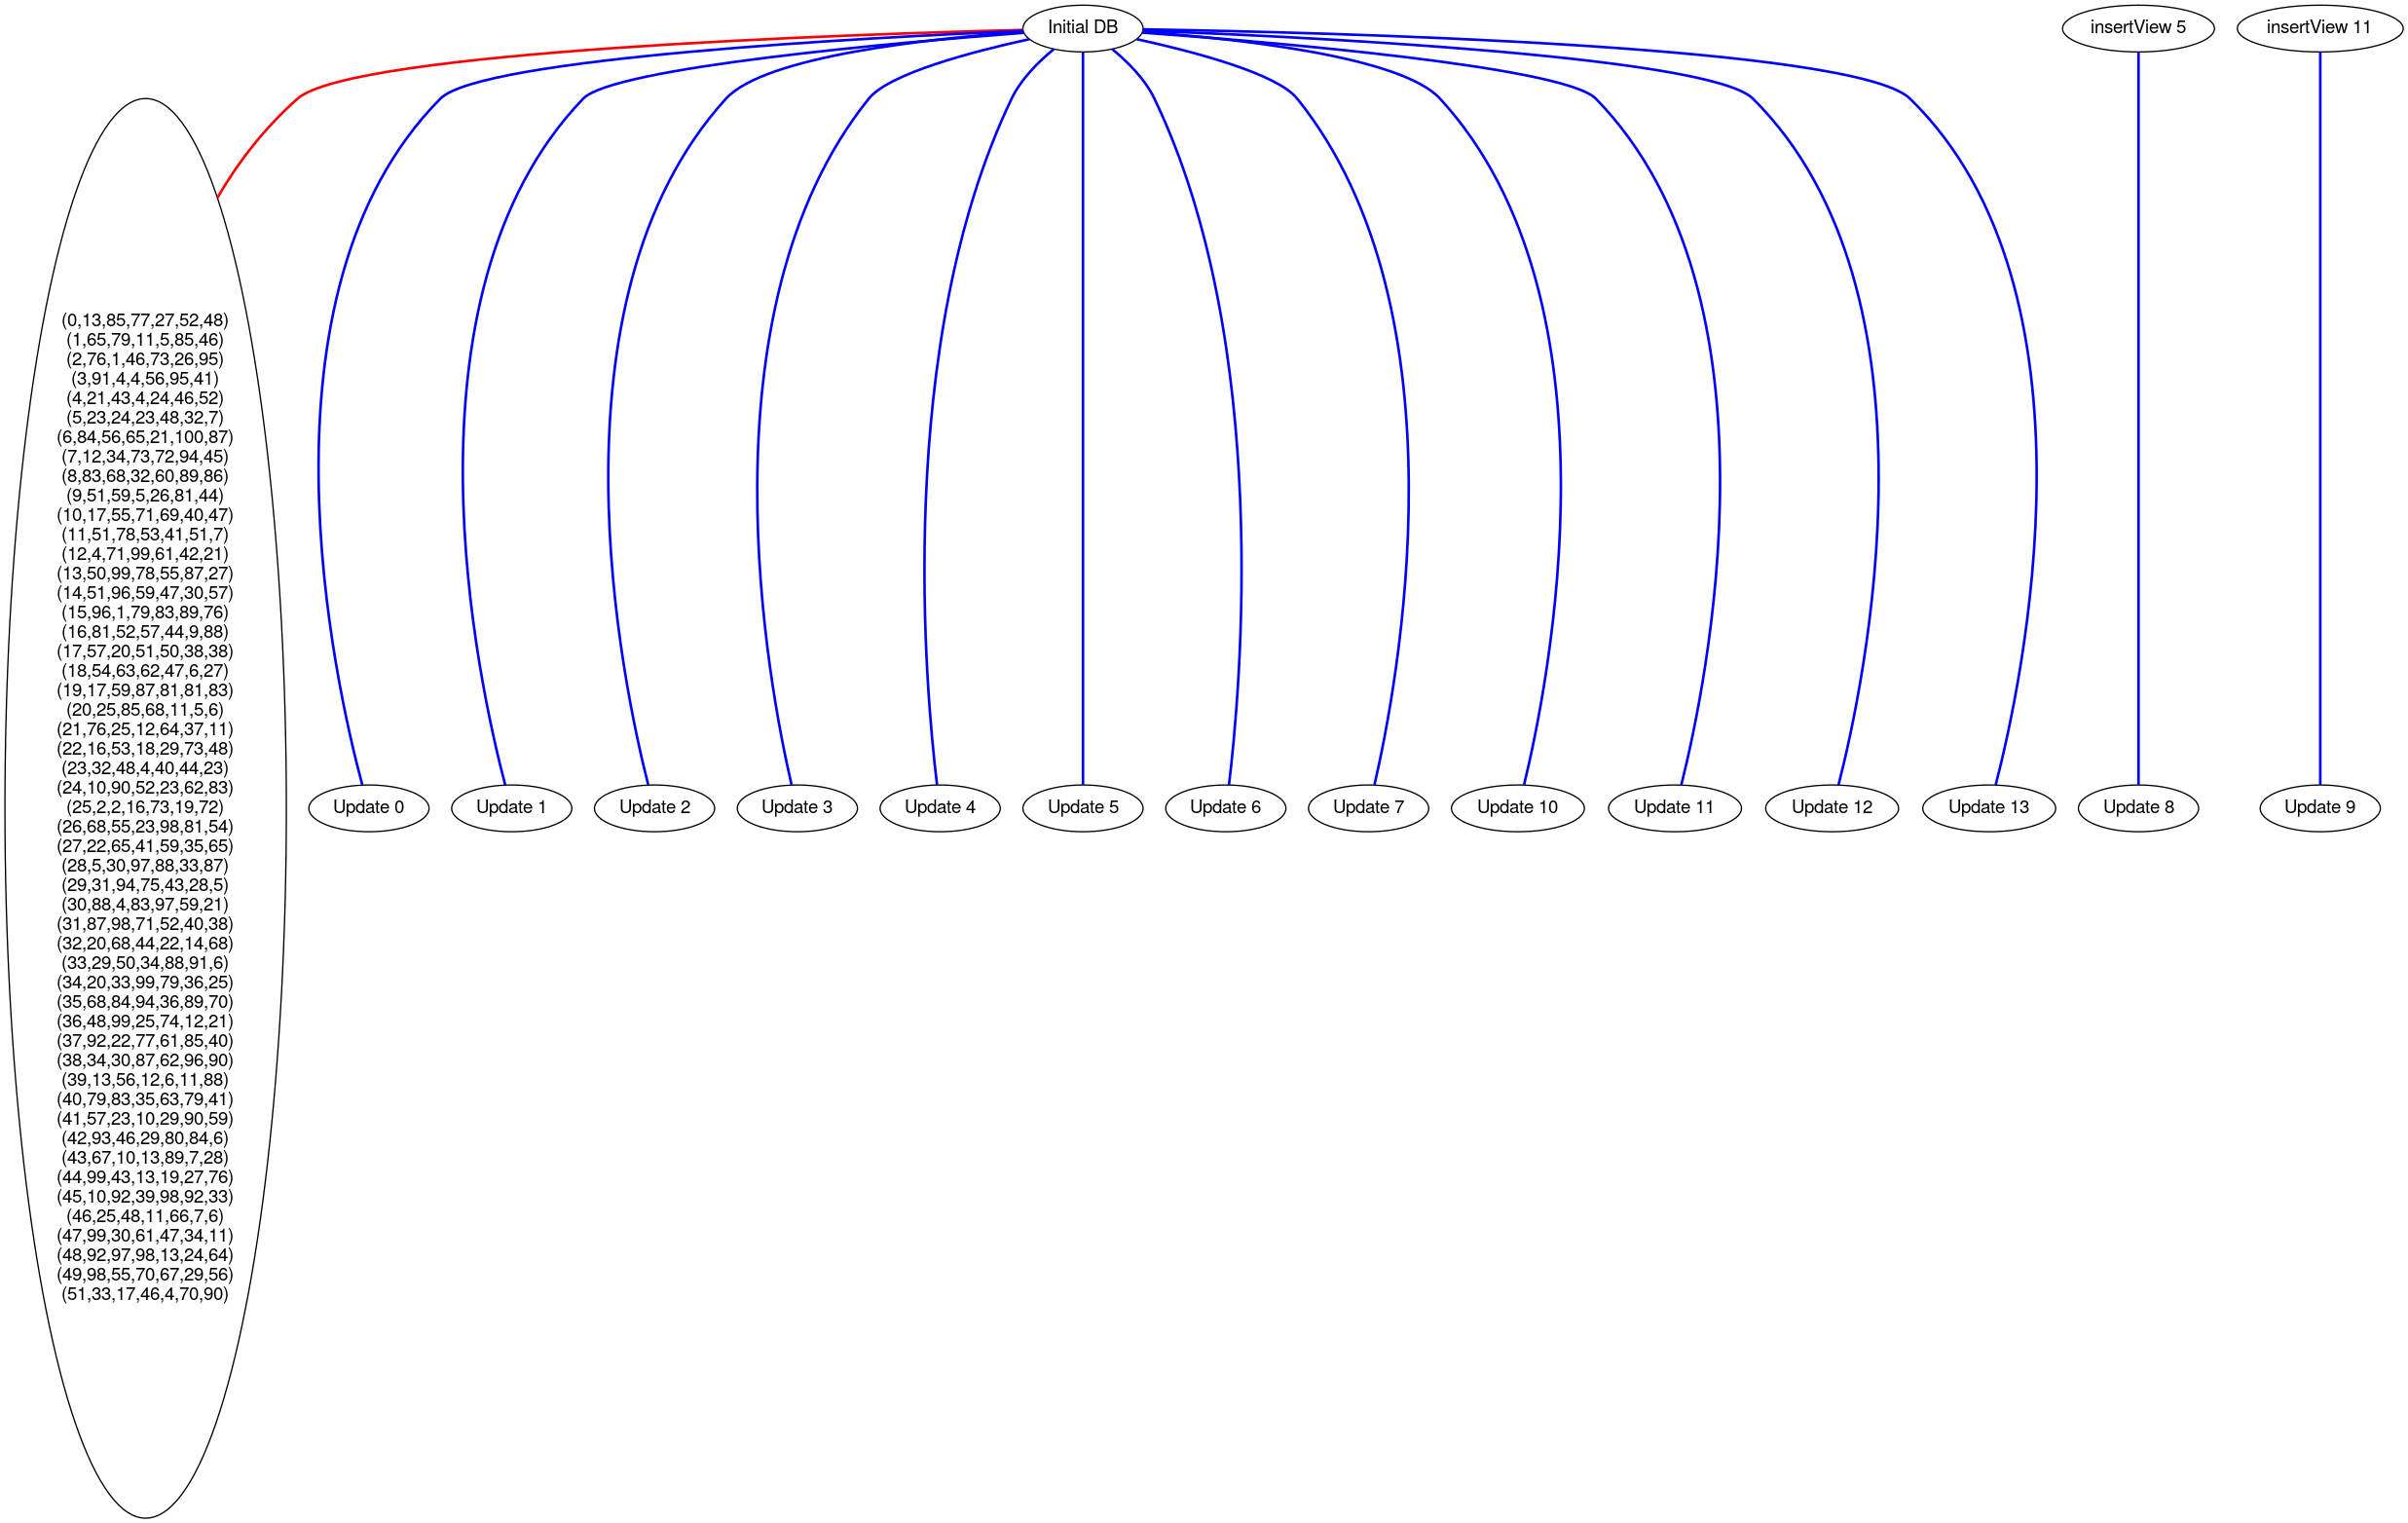

In [384]:
G = nx.Graph()
#start = '\n'.join(startNode) # for full db
start = 'Initial DB' # for names only

edges = []
provlist = []
num = 0
# for inserts in insertNodeList:
#     endInsert = '\n'.join(inserts)
#     G.add_edge(start,endInsert,penwidth=2,color='red')
#     edges.append((start,endInsert)) # for full values
    
for inserts in insertNameDict:
    #endInsert = '\n'.join(inserts)
    G.add_edge(start,endInsert,penwidth=2,color='red')
    edges.append((start,endInsert)) # for names only
    
for prov in provTraces:
    startNodeSingle = []
    endNodeSingle = []
    startNode2Ignore = []
    
    for i, row in pw_rels_dfs['e_3'].iterrows():
        singleProv = [row['DATASTART'][-1],row['TRANS'][2]]
        if singleProv == prov:
            endNodeSingle.append('('+"{}".format(','.join(row['DATAEND'][1:-1])+')'))
            startNode2Ignore.append('('+"{}".format(','.join(row['DATASTART'][1:-1])+')'))
            startProv = row['DATASTART'][-1]

    provlist.append(startProv)
    if len(startProv) == 2:
        startProv = 'start'
    startNodeSingle = nodeDict[startProv] # for full data
    
    endNodeBase = [x for x in nodeDict[startProv] if x not in startNode2Ignore]
    endNodeBase.extend(endNodeSingle)
    
    print(prov)
    prov = prov[1]
    nodeDict[prov] = endNodeBase
    nodeNameDict[prov] = 'Update '+str(num)
    
#     startNodeSingle = '\n'.join(startNodeSingle)# for full data
#     endNodeSingle = '\n'.join(endNodeBase)# for full data
    
    startNodeSingle = nodeNameDict[startProv] # names only
    endNodeSingle = nodeNameDict[prov] # names only
    G.add_edge(startNodeSingle,endNodeSingle,penwidth=2,color='blue')
    edges.append((startNodeSingle, endNodeSingle))
    num += 1

    
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
#G.graph['layout'] = 'fdp'

draw(G)

In [ ]:
G = nx.Graph()
start = '\n'.join(startNode)
edges = []
provlist = []

for inserts in insertNodeList:
    endInsert = '\n'.join(inserts)
    G.add_edge(start,endInsert,penwidth=2,color='red')
    edges.append((start,endInsert))
    
for prov in provTraces:
    startNodeSingle = []
    endNodeSingle = []
    startNode2Ignore = []
    
    for i, row in pw_rels_dfs['e_3'].iterrows():
        #print(row)
#         print([row['DATASTART'][-1],row['TRANS'][2]])
#         print(prov)
        singleProv = [row['DATASTART'][-1],row['TRANS'][2]]
        if singleProv == prov:
            #print('ayayay')
            #endNodeSingle.append(row['DATAEND'][1:-1])
            endNodeSingle.append('('+"{}".format(','.join(row['DATAEND'][1:-1])+')'))
            startNode2Ignore.append('('+"{}".format(','.join(row['DATASTART'][1:-1])+')'))
            
            startProv = row['DATASTART'][-1]
#     print(startProv)
#     print(prov)
    provlist.append(startProv)
    if len(startProv) == 2:
        startProv = 'start'
    #provlist.append(startProv)
    startNodeSingle = nodeDict[startProv]
    print(len(startNodeSingle),'len start')
    endNodeBase = [x for x in nodeDict[startProv] if x not in startNode2Ignore]
    print(len(endNodeBase),'len base')
    endNodeBase.extend(endNodeSingle)
    print(len(endNodeBase),'len final')
    #print(endNodeSingle)
    nodeDict[prov] = endNodeBase
    startNodeSingle = '\n'.join(startNodeSingle)
    endNodeSingle = '\n'.join(endNodeBase)
    G.add_edge(startNodeSingle,endNodeSingle,penwidth=2,color='blue')
    edges.append((startNodeSingle, endNodeSingle))

    
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
#G.graph['layout'] = 'fdp'

draw(G)

In [380]:
a = {}
a['a'] = 1#
b = 1
for key,val in a.items():
    if val == b:
        print(key)
#print(a['a'])

a


In [371]:
insertNode

['(0,13,85,77,27,52,48)',
 '(1,65,79,11,5,85,46)',
 '(2,76,1,46,73,26,95)',
 '(3,91,4,4,56,95,41)',
 '(4,21,43,4,24,46,52)',
 '(5,23,24,23,48,32,7)',
 '(6,84,56,65,21,100,87)',
 '(7,12,34,73,72,94,45)',
 '(8,83,68,32,60,89,86)',
 '(9,51,59,5,26,81,44)',
 '(10,17,55,71,69,40,47)',
 '(11,51,78,53,41,51,7)',
 '(12,4,71,99,61,42,21)',
 '(13,50,99,78,55,87,27)',
 '(14,51,96,59,47,30,57)',
 '(15,96,1,79,83,89,76)',
 '(16,81,52,57,44,9,88)',
 '(17,57,20,51,50,38,38)',
 '(18,54,63,62,47,6,27)',
 '(19,17,59,87,81,81,83)',
 '(20,25,85,68,11,5,6)',
 '(21,76,25,12,64,37,11)',
 '(22,16,53,18,29,73,48)',
 '(23,32,48,4,40,44,23)',
 '(24,10,90,52,23,62,83)',
 '(25,2,2,16,73,19,72)',
 '(26,68,55,23,98,81,54)',
 '(27,22,65,41,59,35,65)',
 '(28,5,30,97,88,33,87)',
 '(29,31,94,75,43,28,5)',
 '(30,88,4,83,97,59,21)',
 '(31,87,98,71,52,40,38)',
 '(32,20,68,44,22,14,68)',
 '(33,29,50,34,88,91,6)',
 '(34,20,33,99,79,36,25)',
 '(35,68,84,94,36,89,70)',
 '(36,48,99,25,74,12,21)',
 '(37,92,22,77,61,85,40)',
 '(3

In [361]:
# provTraces = []
# for i, row in pw_rels_dfs['e_3'].iterrows():
#     provTraces.append(row['DATAEND'][-1][1:])
    
# print(provTraces)
# uniqueProvTraces = set(provTraces)

""
['""', '"A4>=52-A4<62-A2>=80-A2<90"']
""
['""', '"A4>=7-A4<17-A2>=55-A2<65"']
""
['""', '"A0>=78-A0<88-A4>=87-A4<97"']
""
['""', '"A0>=62-A0<72-A4>=84-A4<94"']
""
['""', '"A0>=62-A0<72-A4>=84-A4<94"']
""
['""', '"A4>=28-A4<38-A2>=18-A2<28"']
""
['""', '"A4>=51-A4<61-A2>=83-A2<93"']
""
['""', '"A4>=45-A4<55-A2>=75-A2<85"']
"INSERT52-90-80-74-91-77-79"
['"INSERT52-90-80-74-91-77-79"', '"A4>=68-A4<78-A2>=65-A2<75"']
"INSERT50-82-4-4-63-28-53"
['"INSERT50-82-4-4-63-28-53"', '"A4>=24-A4<34-A2>=3-A2<13"']
""
['""', '"A1>=35-A1<45-A4>=44-A4<54"']
""
['""', '"A1>=53-A1<63-A4>=80-A4<90"']
""
['""', '"A1>=53-A1<63-A4>=80-A4<90"']
""
['""', '"A1>=53-A1<63-A4>=80-A4<90"']


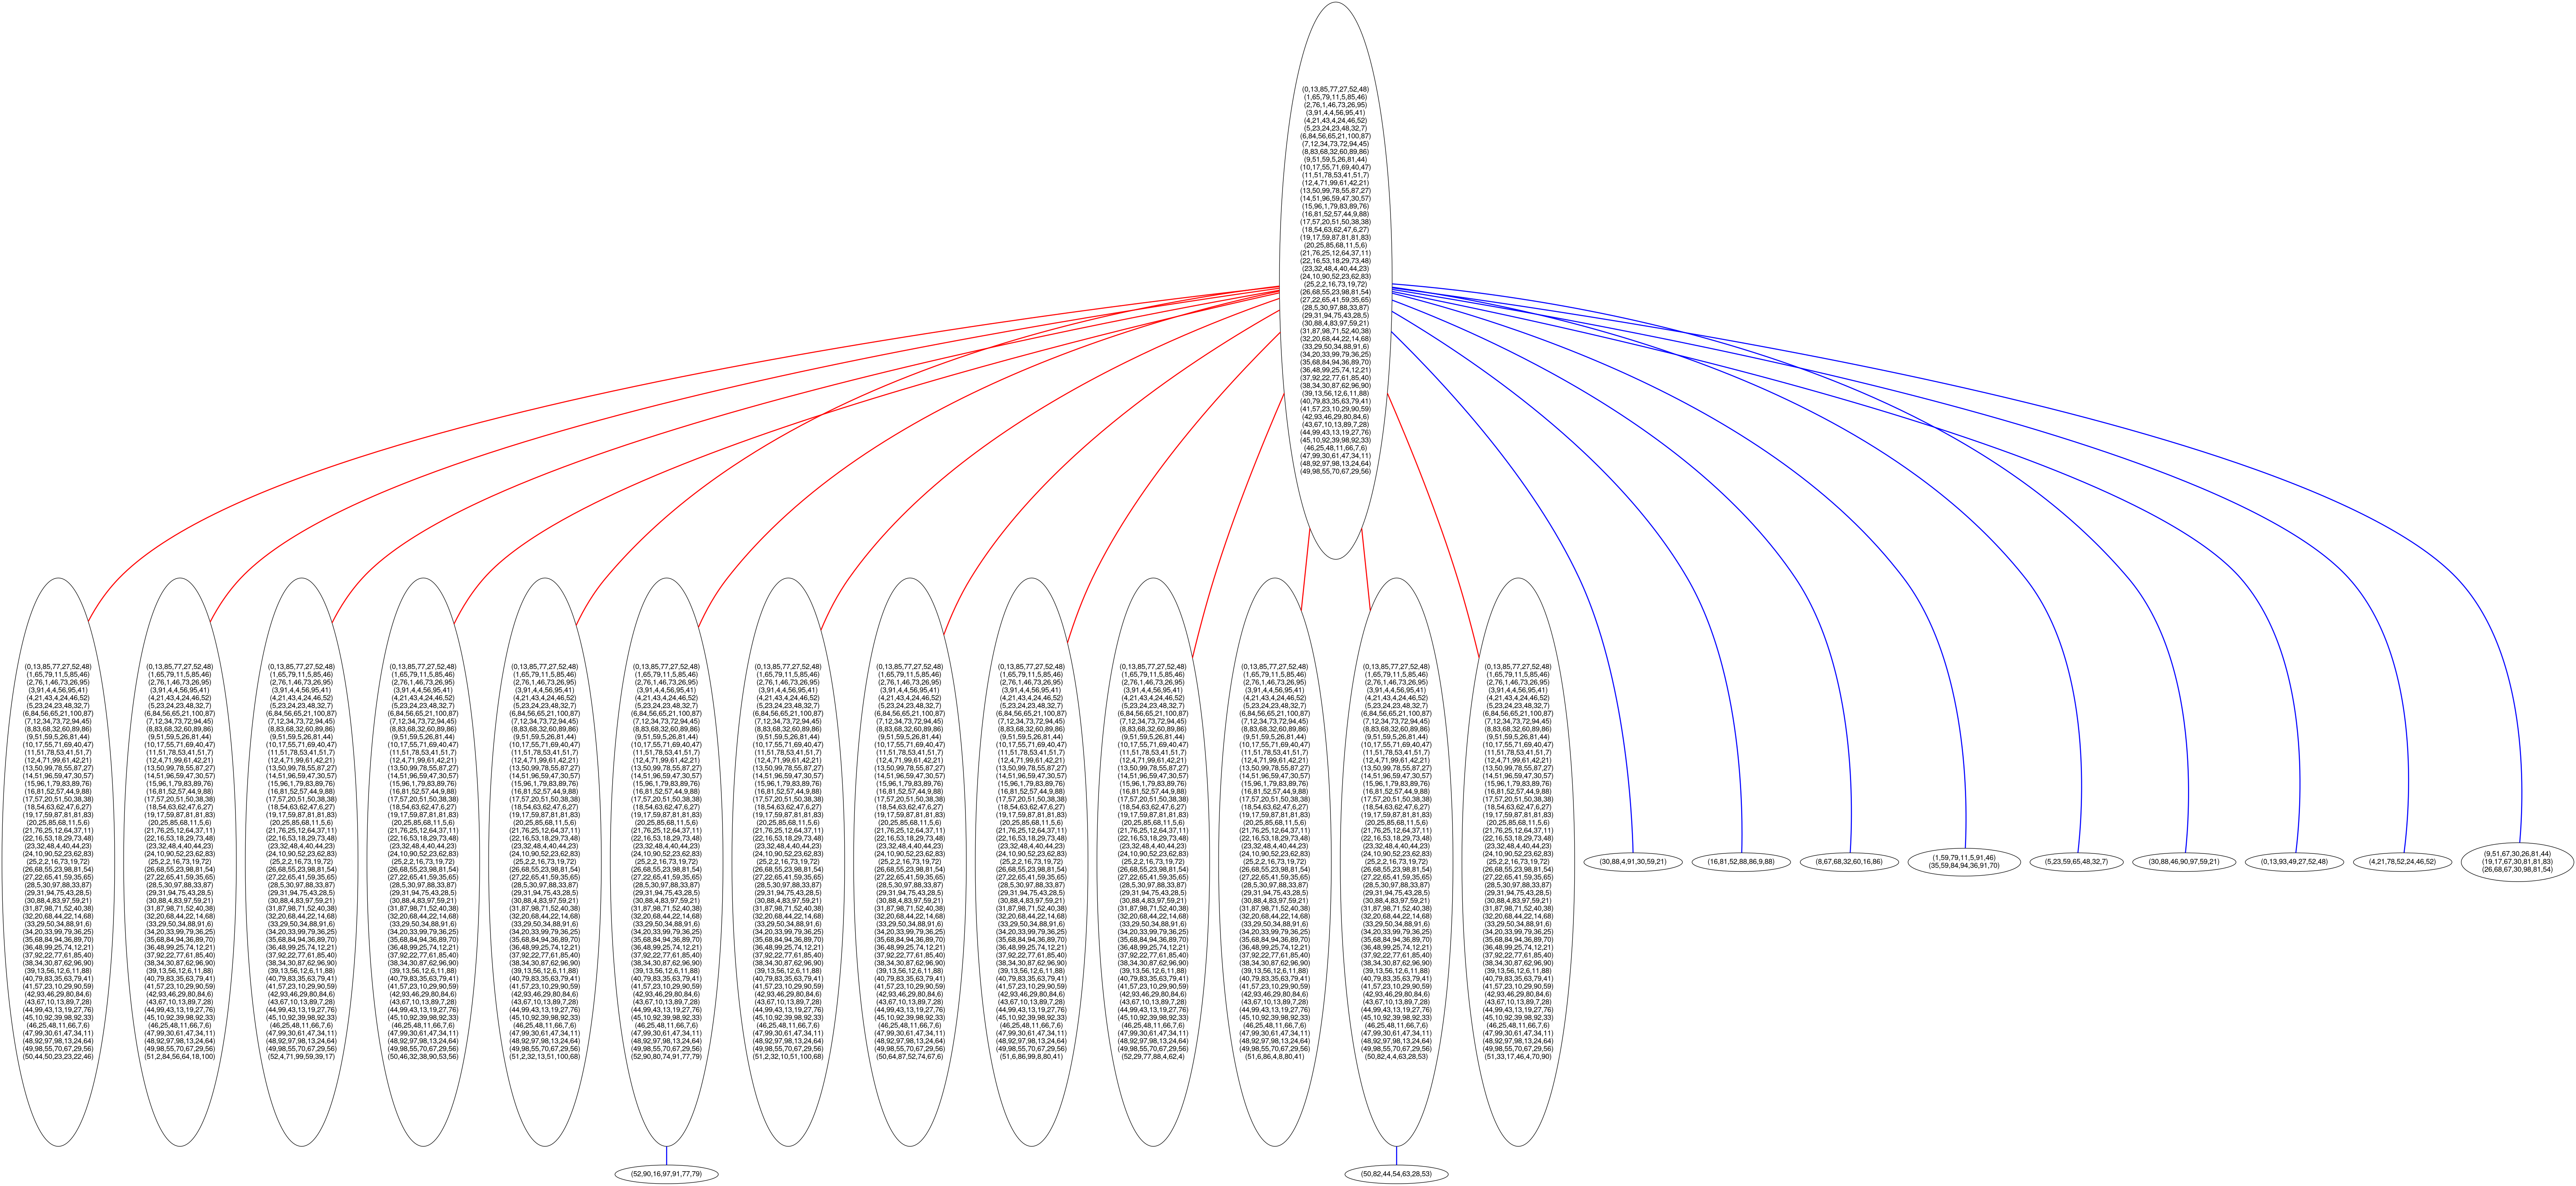

In [359]:
G = nx.Graph()
start = '\n'.join(startNode)
edges = []
provlist = []

for inserts in insertNodeList:
    endInsert = '\n'.join(inserts)
    G.add_edge(start,endInsert,penwidth=2,color='red')
    edges.append((start,endInsert))
    
for prov in provTraces:
    startNodeSingle = []
    endNodeSingle = []
    for i, row in pw_rels_dfs['e_3'].iterrows():
        #print(row)
#         print([row['DATASTART'][-1],row['TRANS'][2]])
#         print(prov)
        singleProv = [row['DATASTART'][-1],row['TRANS'][2]]
        if singleProv == prov:
            #print('ayayay')
            #endNodeSingle.append(row['DATAEND'][1:-1])
            endNodeSingle.append('('+"{}".format(','.join(row['DATAEND'][1:-1])+')'))
            
            startProv = row['DATASTART'][-1]
    print(startProv)
    print(prov)
    provlist.append(startProv)
    if len(startProv) == 2:
        startProv = 'start'
    #provlist.append(startProv)
    startNodeSingle = nodeDict[startProv]
    #print(endNodeSingle)
    startNodeSingle = '\n'.join(startNodeSingle)
    endNodeSingle = '\n'.join(endNodeSingle)
    G.add_edge(startNodeSingle,endNodeSingle,penwidth=2,color='blue')
    edges.append((startNodeSingle, endNodeSingle))

    
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
#G.graph['layout'] = 'fdp'

draw(G)

In [352]:
provlist

['""',
 '""',
 '""',
 '""',
 '""',
 '""',
 '""',
 '""',
 '""',
 '""',
 '""',
 '""',
 '""',
 '""']

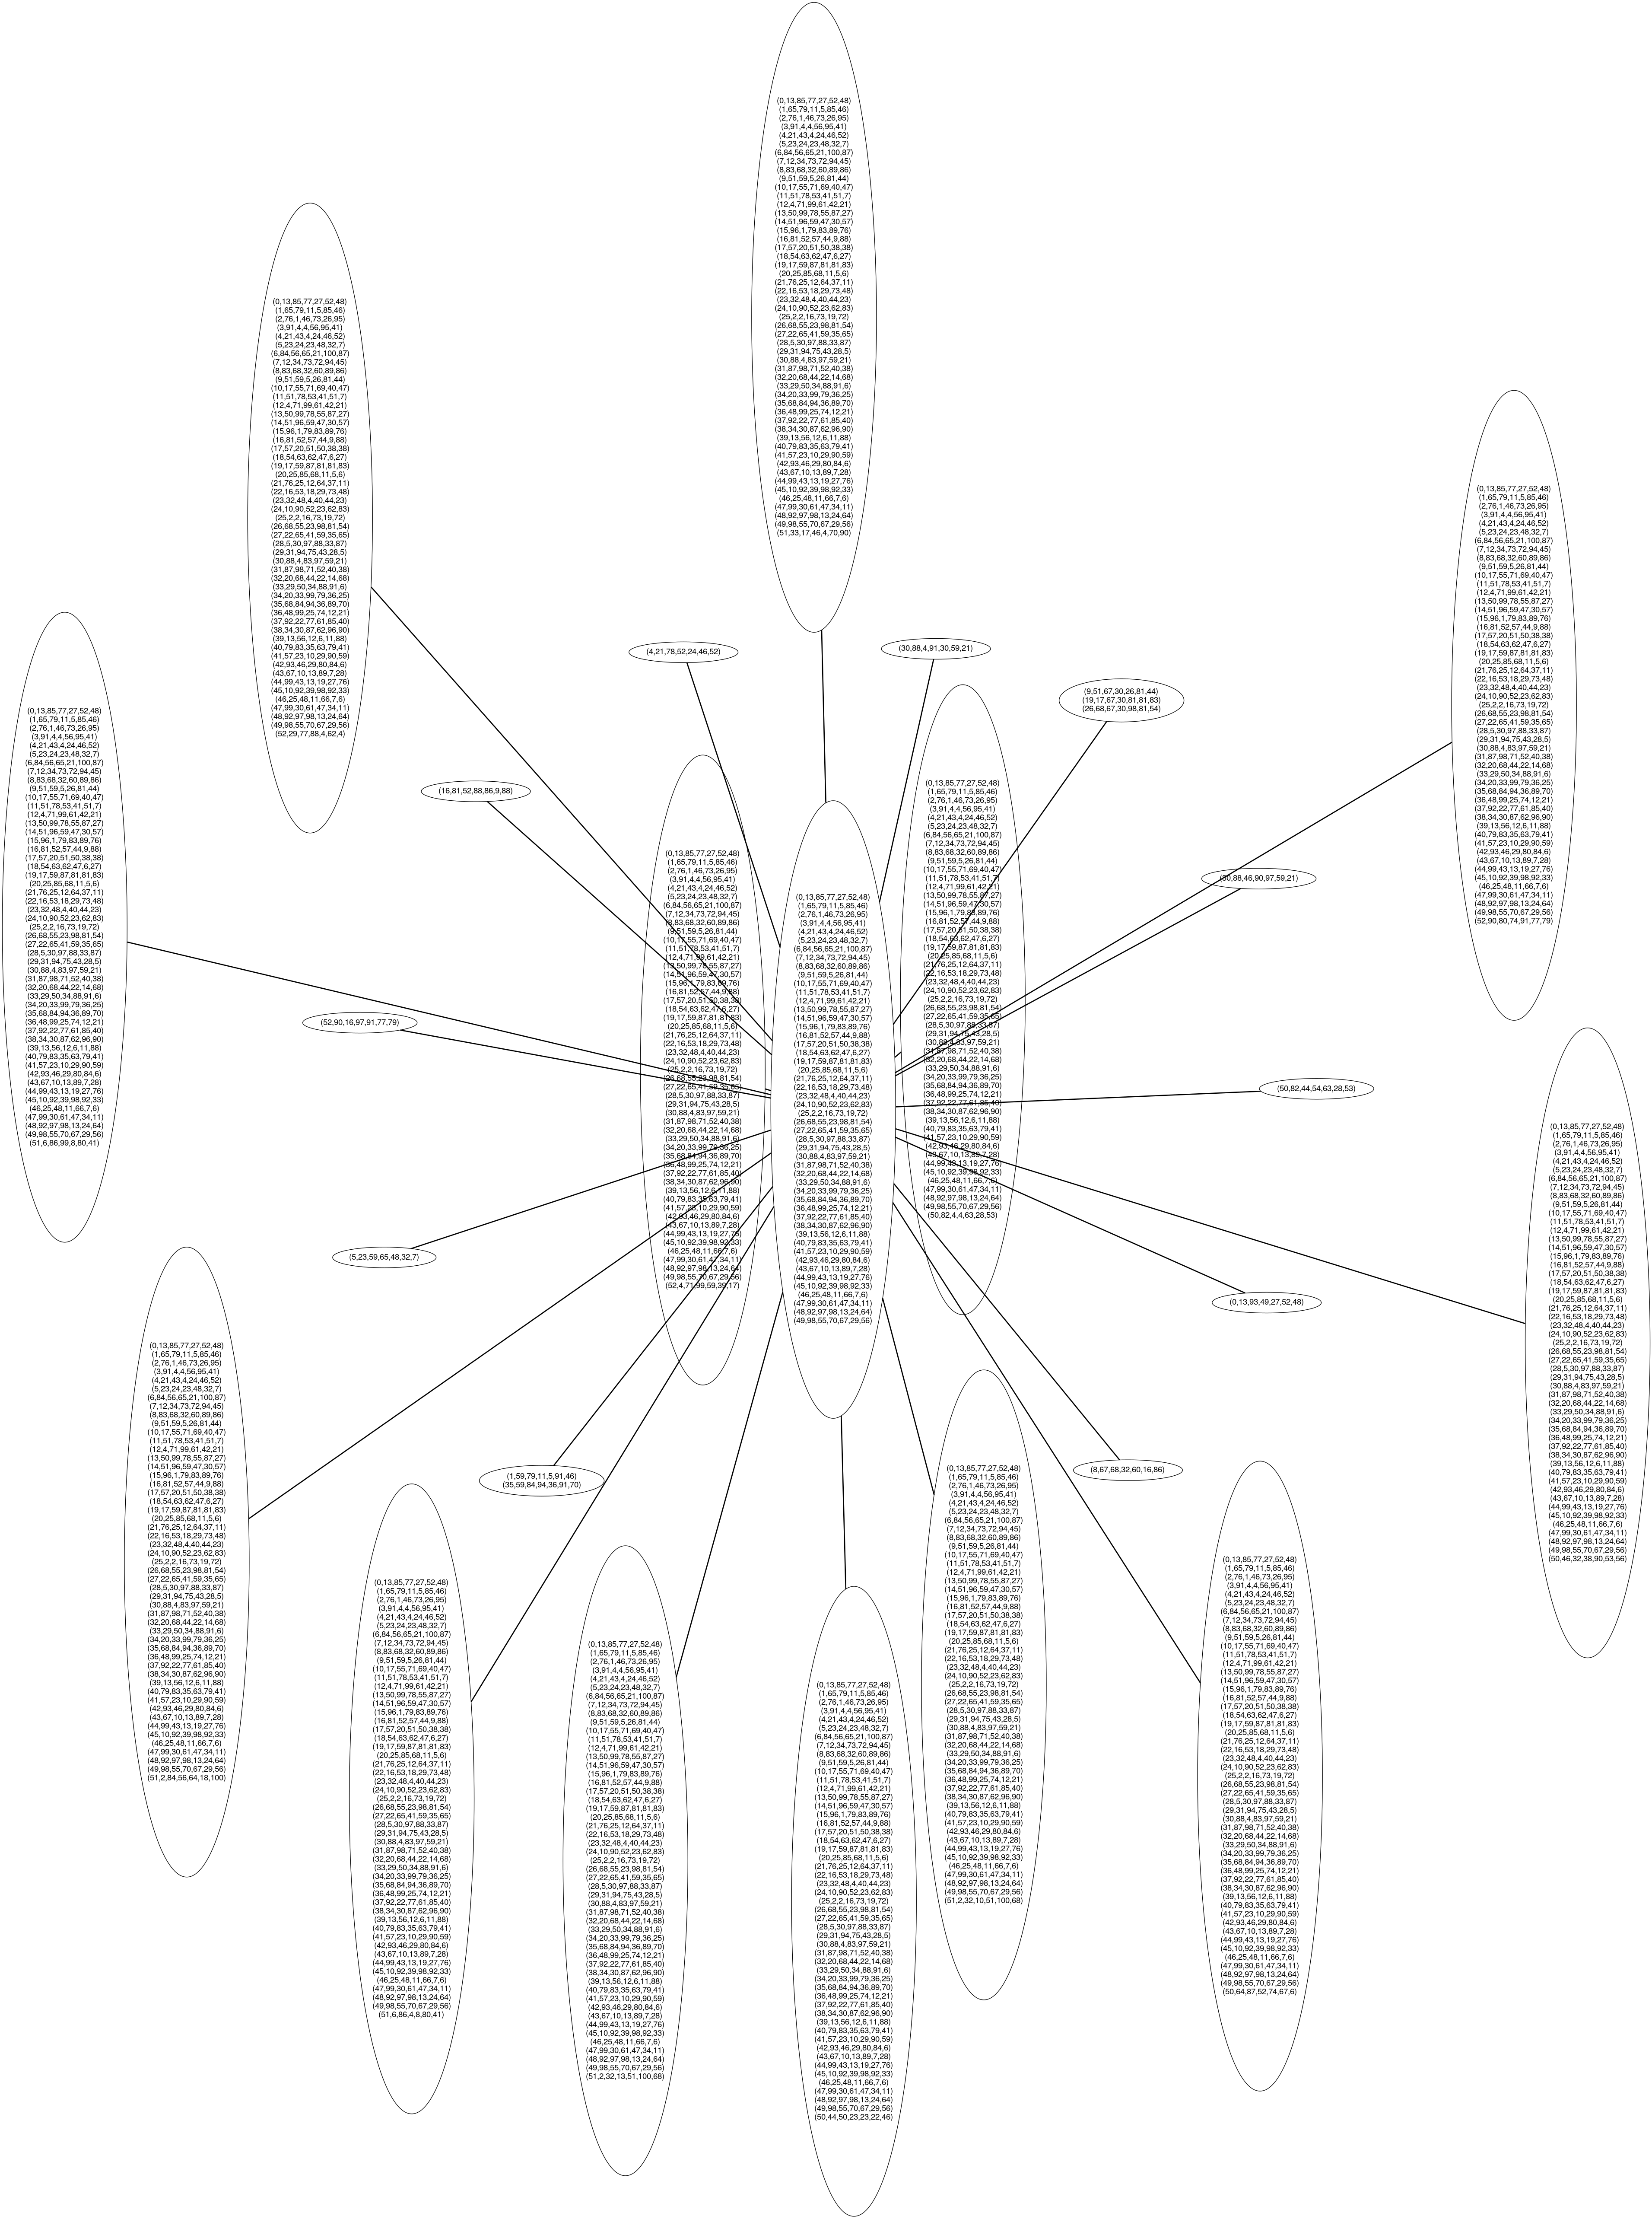

In [347]:
G = nx.Graph()
start = '\n'.join(startNode)
edges = []

for inserts in insertNodeList:
    endInsert = '\n'.join(inserts)
    G.add_edge(start,endInsert,penwidth=2,colour='red')
    edges.append((start,endInsert))
    
for prov in provTraces:
    startNodeSingle = []
    endNodeSingle = []
    for i, row in pw_rels_dfs['e_3'].iterrows():
        #print(row)
#         print([row['DATASTART'][-1],row['TRANS'][2]])
#         print(prov)
        singleProv = [row['DATASTART'][-1],row['TRANS'][2]]
        if singleProv == prov:
            #print('ayayay')
            #endNodeSingle.append(row['DATAEND'][1:-1])
            endNodeSingle.append('('+"{}".format(','.join(row['DATAEND'][1:-1])+')'))
            
    startProv = row['DATASTART'][-1]
    if len(startProv) == 2:
        startProv = 'start'
    
    startNodeSingle = nodeDict[startProv]
    #print(endNodeSingle)
    startNodeSingle = '\n'.join(startNodeSingle)
    endNodeSingle = '\n'.join(endNodeSingle)
    G.add_edge(startNodeSingle,endNodeSingle,penwidth=2,colour='blue')
    edges.append((startNodeSingle, endNodeSingle))

    
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
G.graph['layout'] = 'fdp'

draw(G)

In [211]:
startNodesTr = []
#endN
for i, row in pw_rels_dfs['e_3'].iterrows():
    startNodesTr.append(row['DATASTART'][1:-1])

In [153]:
G = nx.Graph()

edges = []
start_col_names = ['ID','A0','A1','A2','A3','A4','A5']
end_col_names = ['ENDID','ENDA0','ENDA1','ENDA2','ENDA3','ENDA4','ENDA5']

startList = []
endList = []

for i, row in pwe_e3_new_format.iterrows():
    start_node = '('+"{}".format(','.join([row[col] for col in start_col_names]))+')'
    end_node = '('+"{}".format(','.join([row[col] for col in end_col_names]))+')'
    startList.append(start_node)
    endList.append(end_node)
    G.add_edge(start_node, end_node, penwidth=2,color=row['COLOUR'])
    edges.append((start_node, end_node))
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
G.graph['layout'] = 'fdp'

draw(G)
    
# G.graph['rankdir'] = 'TB'

KeyError: 'ENDID'

In [5]:
q = "UPDATE configs SET %s WHERE id = :cid"

In [6]:
allkeys = ['KEY','KEY','key']

allkeys =  [N_D: 50, N_q: 10, N_dim: 6, idx: 0.5]

args = ", ".join(["%s = :%s" % (k.lower(), k) for k in allkeys])
q = q % args

In [7]:
q

'UPDATE configs SET key = :KEY, key = :KEY, key = :key WHERE id = :cid'

In [8]:
from configgen import KeyValue

ModuleNotFoundError: No module named 'configgen'